In this notebook we will briefly talk about what deep learning is is and then apply it to our data and then we will evaluate our model

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import losses

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Next, we import the functions from our original data exploration notebook. These will be used to get our data clean enough to be fed to our models.

In [ ]:
# FUNCTIONS FROM NOTEBOOK 1

def merge_data(country_data, height_data):
  height_data = height_data.rename(columns={"Country Name" : "Country"})
  country_data['Country'] = country_data.apply(lambda row : row.astype(str)['Country'][:-1], axis=1)
  old_names = ['Antigua & Barbuda', 'Bahamas, The', 'Bosnia & Herzegovina', 'Central African Rep.', 'Congo, Dem. Rep.', 'Swaziland', 'Gambia, The', 'Cote d\'Ivoire',
             'Micronesia, Fed. St.', 'Burma', 'Korea, North', 'Macedonia', 'Congo, Repub. of the', 'Saint Kitts & Nevis', 'Sao Tome & Principe',
             'Korea, South', 'East Timor', 'Trinidad & Tobago']

  new_names = ['Antigua and Barbuda', 'Bahamas', 'Bosnia and Herzegovina', 'Central African Republic', 'DR Congo', 'Eswatini', 'Gambia', 'Ivory Coast', 'Micronesia',
              'Myanmar', 'North Korea', 'North Macedonia', 'Republic of the Congo', 'Saint Kitts and Nevis', 'Sao Tome and Principe', 'South Korea',
              'Timor-Leste', 'Trinidad and Tobago']

  for i in range(len(old_names)):
    country_data['Country'].replace({old_names[i]: new_names[i]}, inplace=True)
  
  merged_df = pd.merge(country_data, height_data, on=['Country'])
  return merged_df

# FUNCTIONS FROM NOTEBOOK 2

def rename_regions(row):
  if row['Region'] == 'ASIA (EX. NEAR EAST)':
    region = 'ASIA'
  elif row['Region'] == 'NEAR EAST':
    region = 'MIDDLE EAST'
  elif row['Region'] == 'C.W. OF IND. STATES':
    region = "C.W.I. STATES"
  else:
    region = row['Region']
  return region

def format_and_clean_data(merged_data):
  merged_data['Region'] = merged_data.apply(lambda row : row.astype(str)['Region'].strip(), axis=1)
  merged_data['Region'] = merged_data.apply(lambda row : rename_regions(row), axis=1)

  for col in merged_data.columns.values:
    if merged_data[col].isnull().sum() == 0:
        continue
    if col == 'Climate':
        guess_values = merged_data.groupby('Region')['Climate'].apply(lambda x: x.mode().max())
    else:
        guess_values = merged_data.groupby('Region')[col].median()
    for region in merged_data['Region'].unique():
        merged_data[col].loc[(merged_data[col].isnull())&(merged_data['Region']==region)] = guess_values[region]
  return merged_data

# FUNCTIONS FROM NOTEBOOK 3

def get_gdp_dataset(merged_data):
  merged_data = merged_data.drop(['Male Height in Cm', 'Female Height in Cm'], axis=1)
  merged_data['Average Height in Ft'] = merged_data['Female Height in Ft'] / 2 + merged_data['Male Height in Ft'] / 2
  merged_data = merged_data.drop(['Male Height in Ft', 'Female Height in Ft'], axis=1)

  GDP_features = ['GDP ($ per capita)', 'Infant mortality (per 1000 births)', 'Net migration', 'Pop. Density (per sq. mi.)',
                'Literacy (%)', 'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry', 'Service']
  gdp_data = merged_data[GDP_features]
  
  return gdp_data

def get_height_dataset(merged_data):
  merged_data = merged_data.drop(['Male Height in Cm', 'Female Height in Cm'], axis=1)
  merged_data['Average Height in Ft'] = merged_data['Female Height in Ft'] / 2 + merged_data['Male Height in Ft'] / 2
  merged_data = merged_data.drop(['Male Height in Ft', 'Female Height in Ft'], axis=1)

  height_features = ['Average Height in Ft', 'Agriculture', 'Service', 'Phones (per 1000)', 'GDP ($ per capita)', 'Literacy (%)']
  avg_height_data = merged_data[height_features]

  return avg_height_data

Now we will use the functions that we set up to load up the data

In [ ]:
height_data = pd.read_csv('../content/sample_data/Height of Male and Female by Country 2022.csv')
country_data = pd.read_csv('../content/sample_data/countries of the world.csv', decimal=',')

merged_data = merge_data(country_data, height_data)
merged_data = format_and_clean_data(merged_data)
gdp_data = get_gdp_dataset(merged_data)
avg_height_data = get_height_dataset(merged_data)

gdp_data.head()

,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
0,700.0,163.07,23.06,48.0,36.0,3.2,46.60,0.380,0.240,0.380
1,4500.0,21.52,-4.93,124.6,86.5,71.2,15.11,0.232,0.188,0.579
2,6000.0,31.00,-0.39,13.8,70.0,78.1,17.14,0.101,0.600,0.298
3,8000.0,9.27,-20.71,290.4,97.0,259.5,22.46,0.151,0.190,0.620
4,19000.0,4.05,6.60,152.1,100.0,497.2,8.71,0.021,0.274,0.707


In [ ]:
avg_height_data.head()

,Average Height in Ft,Agriculture,Service,Phones (per 1000),GDP ($ per capita),Literacy (%)
0,5.325,0.380,0.380,3.2,700.0,36.0
1,5.515,0.232,0.579,71.2,4500.0,86.5
2,5.535,0.101,0.298,78.1,6000.0,70.0
3,5.655,0.151,0.620,259.5,8000.0,97.0
4,5.650,0.021,0.707,497.2,19000.0,100.0


Whenever we train a model, its important to split it up into a training data set and a test data set. The main reason we do this is to make sure that the model learns the patterns in the data instead of just memorizing the entire dataset. Basically, we want to make sure that the model doesn't overfit on the data. Its like when you get a review for a test, you are given questions that are similar to the test but not the exact same question to make sure you can't just memorize the questions on the review.

In [ ]:
train, test = train_test_split(gdp_data, test_size=0.3, shuffle=True)
training_features = ['Infant mortality (per 1000 births)',
       'Net migration', 'Pop. Density (per sq. mi.)', 'Literacy (%)',
       'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry',
       'Service']
target = 'GDP ($ per capita)'
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

In [ ]:
train_X.shape

(136, 9)

In the next block, we create our model using Tensorflow. Tensorflow makes it super easy to set up the model and train it on the data, simply create the model and how may neurons there should be at each layer, then give it the training data and it will start to learn. After the model is trained, we feed it the test data and compare its answers to the actual answers. This allows us to evaluate how good of a model it is. For our first metric we are using mean absolute error. This is how far from the correct answer the model is on average. Then we use the .describe() function to see what the standard diviation of the dataset to get a better idea of how good or bad the mean average error is in relation to the actual dataset.

In [ ]:
model = Sequential()

# The Input Layer :
model.add(Dense(128, kernel_initializer='normal',input_dim = 9, activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1280      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_X, train_Y, epochs=15, batch_size=32)

Epoch 1/15
5/5 [==============================] - 0s 10ms/step - loss: 3021.2683 - mean_absolute_error: 3021.2683
Epoch 2/15
5/5 [==============================] - 0s 8ms/step - loss: 2955.6035 - mean_absolute_error: 2955.6035
Epoch 3/15
5/5 [==============================] - 0s 8ms/step - loss: 3061.7390 - mean_absolute_error: 3061.7390
Epoch 4/15
5/5 [==============================] - 0s 5ms/step - loss: 2981.6460 - mean_absolute_error: 2981.6460
Epoch 5/15
5/5 [==============================] - 0s 5ms/step - loss: 2981.9097 - mean_absolute_error: 2981.9097
Epoch 6/15
5/5 [==============================] - 0s 7ms/step - loss: 2999.8115 - mean_absolute_error: 2999.8115
Epoch 7/15
5/5 [==============================] - 0s 6ms/step - loss: 2947.8562 - mean_absolute_error: 2947.8562
Epoch 8/15
5/5 [==============================] - 0s 6ms/step - loss: 2937.4785 - mean_absolute_error: 2937.4785
Epoch 9/15
5/5 [==============================] - 0s 7ms/step - loss: 2910.9937 - mean_absolute

In [ ]:
predictions = model.predict(test_X)

In [ ]:
print(mean_absolute_error(predictions, test_Y))

2664.181889938096


We will also try to create a discrete prediction with our linear regression model. To achieve this, we break up the different GDPs into 5 equally sized buckets. These represent a label, either very poor, poor, average, wealthy or very wealthy

In [ ]:
gdp_data['GDP ($ per capita)'] = pd.qcut(gdp_data['GDP ($ per capita)'], 5, labels=False)
gdp_data.describe()

,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
count,195.000000,195.000000,195.000000,195.000000,195.00000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2.000000,38.936846,-0.437077,201.308205,82.29641,198.387179,22.889744,0.158349,0.293564,0.547195
std,1.417854,36.382098,4.466701,667.646406,20.01014,199.670583,11.359249,0.149453,0.135160,0.154904
min,0.000000,2.290000,-20.990000,0.000000,17.60000,0.200000,7.290000,0.000000,0.040000,0.062000
25%,1.000000,10.020000,-1.315000,26.800000,69.95000,27.100000,12.835000,0.039000,0.203500,0.425500
50%,2.000000,24.310000,0.000000,69.800000,92.30000,131.800000,20.690000,0.112000,0.275000,0.560000
75%,3.000000,62.550000,0.305000,151.000000,98.00000,305.550000,30.815000,0.231000,0.349000,0.665000
max,4.000000,191.190000,23.060000,6482.200000,100.00000,898.000000,50.730000,0.769000,0.906000,0.906000


We will have to retrain the model with the new labels. In the next block we reset the data but with the new labels and then feed it into our linear regression model again.

In [ ]:
train, test = train_test_split(gdp_data, test_size=0.3, shuffle=True)
training_features = ['Infant mortality (per 1000 births)',
       'Net migration', 'Pop. Density (per sq. mi.)', 'Literacy (%)',
       'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry',
       'Service']
target = 'GDP ($ per capita)'
train_X = train[training_features]
train_Y = train[target]
test_X = test[training_features]
test_Y = test[target]

In [ ]:
model = Sequential()

# The Input Layer :
model.add(Dense(128, kernel_initializer='normal',input_dim = 9, activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(5, kernel_initializer='normal'))

# Compile the network :
model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

adj_train_Y = []
for row in train_Y:
  new_row = [0, 0, 0, 0, 0]
  new_row[row] = 1
  adj_train_Y.append(new_row)
adj_train_Y = np.array(adj_train_Y)
model.fit(train_X, adj_train_Y, epochs=15, batch_size=32)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               1280      
                                                                 
 dense_41 (Dense)            (None, 256)               33024     
                                                                 
 dense_42 (Dense)            (None, 256)               65792     
                                                                 
 dense_43 (Dense)            (None, 256)               65792     
                                                                 
 dense_44 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 167,173
Trainable params: 167,173
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
5/5 [==============================] 

Because this is a discrete model, we can create a confusion matrix to see where the model is going wrong and see what it is misclassifying. This is a great way to visualize the evaluation metrics. For this confusion matrix, we use sklearn.metrics.

In [ ]:
predictions = model.predict(test_X)
adj_predictions = []
for prediction in predictions:
  largest_index = np.where(prediction == max(prediction))
  adj_predictions.append(largest_index[0])
adj_predictions = np.array(adj_predictions)
cf_matrix = confusion_matrix(np.array(test_Y), adj_predictions)
cf_matrix

array([[ 7,  6,  1,  0,  0],
       [ 1,  4,  5,  0,  0],
       [ 0,  0,  9,  1,  0],
       [ 0,  0,  3,  6,  3],
       [ 0,  0,  0,  1, 12]])

With our confusion matrix set up, we will now set up the heatmap to show it off in a more visually appealing way. We will need to create the title, x-axis label, y-axis label, and the different labels for the different sections.

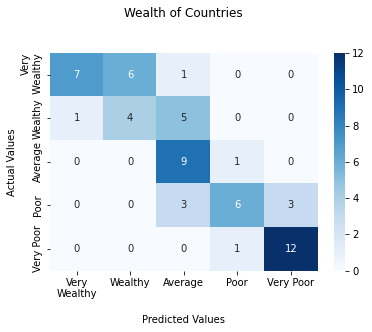

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Very\nWealthy','Wealthy','Average','Poor','Very Poor'])
ax.yaxis.set_ticklabels(['Very\n Wealthy','Wealthy','Average','Poor','Very Poor'])

plt.show()

For the next confusion matrix, I wanted to see the % of each answer within a row.

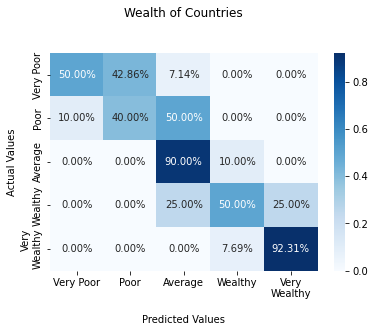

In [ ]:
cf_matrix = confusion_matrix(np.array(test_Y), adj_predictions)
percent_matrix = []
for i in range(len(cf_matrix)):
  percent_matrix.append(cf_matrix[i]/sum(cf_matrix[i]))

ax = sns.heatmap(percent_matrix, annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])
ax.yaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])

plt.show()

Finally, we will print out the raw accuacy of our model, meaning how often it labeled the country correctly.

In [ ]:
accuracy_score(np.array(test_Y), adj_predictions)

0.6440677966101694